In [31]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            precision_recall_curve, average_precision_score, \
                            roc_auc_score
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display

## Loading and preprocessing

##### Length distribution of the intertexts

In [32]:
intertexts = pd.read_excel('../data/intertexts.xlsx')
print(len(intertexts))
intertexts.sample(5)

229


,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
97,mor-mou-16,Moriaen,Hie deetse bat achtergaen.,Riddere metter mouwen,Ende dadense also achtergaen.,1,Van der Stempel 1930,Editions have achterstaen. Might not be a link.
145,lan-ele-21,Lantsloot van der Haghedochte,Mar ic segghe v dat ic v rade Omme te bescuwene meere scade:,Moriaen,oft gi werken wilt bi rade Ende scuwen wilt vwe scade.,2,"Heeroma 1973b, Moriaen (II)",NaN
8,mor-ele-9,Moriaen,God hi mach v wel gesterken.,Karel ende Elegast,Nv so moetti - God - mi gestercken:,1,"Heeroma 1973a, Moriaen (I)",NaN
84,mor-mou-4,Moriaen,Doe hi achters van u sciet,Riddere metter mouwen,Doe hi achters van hem sciet,1,Van der Stempel 1917,Double case
25,mor-ele-26,Moriaen,En ontfinc noit vlecge no scard.,Karel ende Elegast,Ende ontfingen scarde ende vlegghen:,1,"Heeroma 1973a, Moriaen (I)",NaN


In [33]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

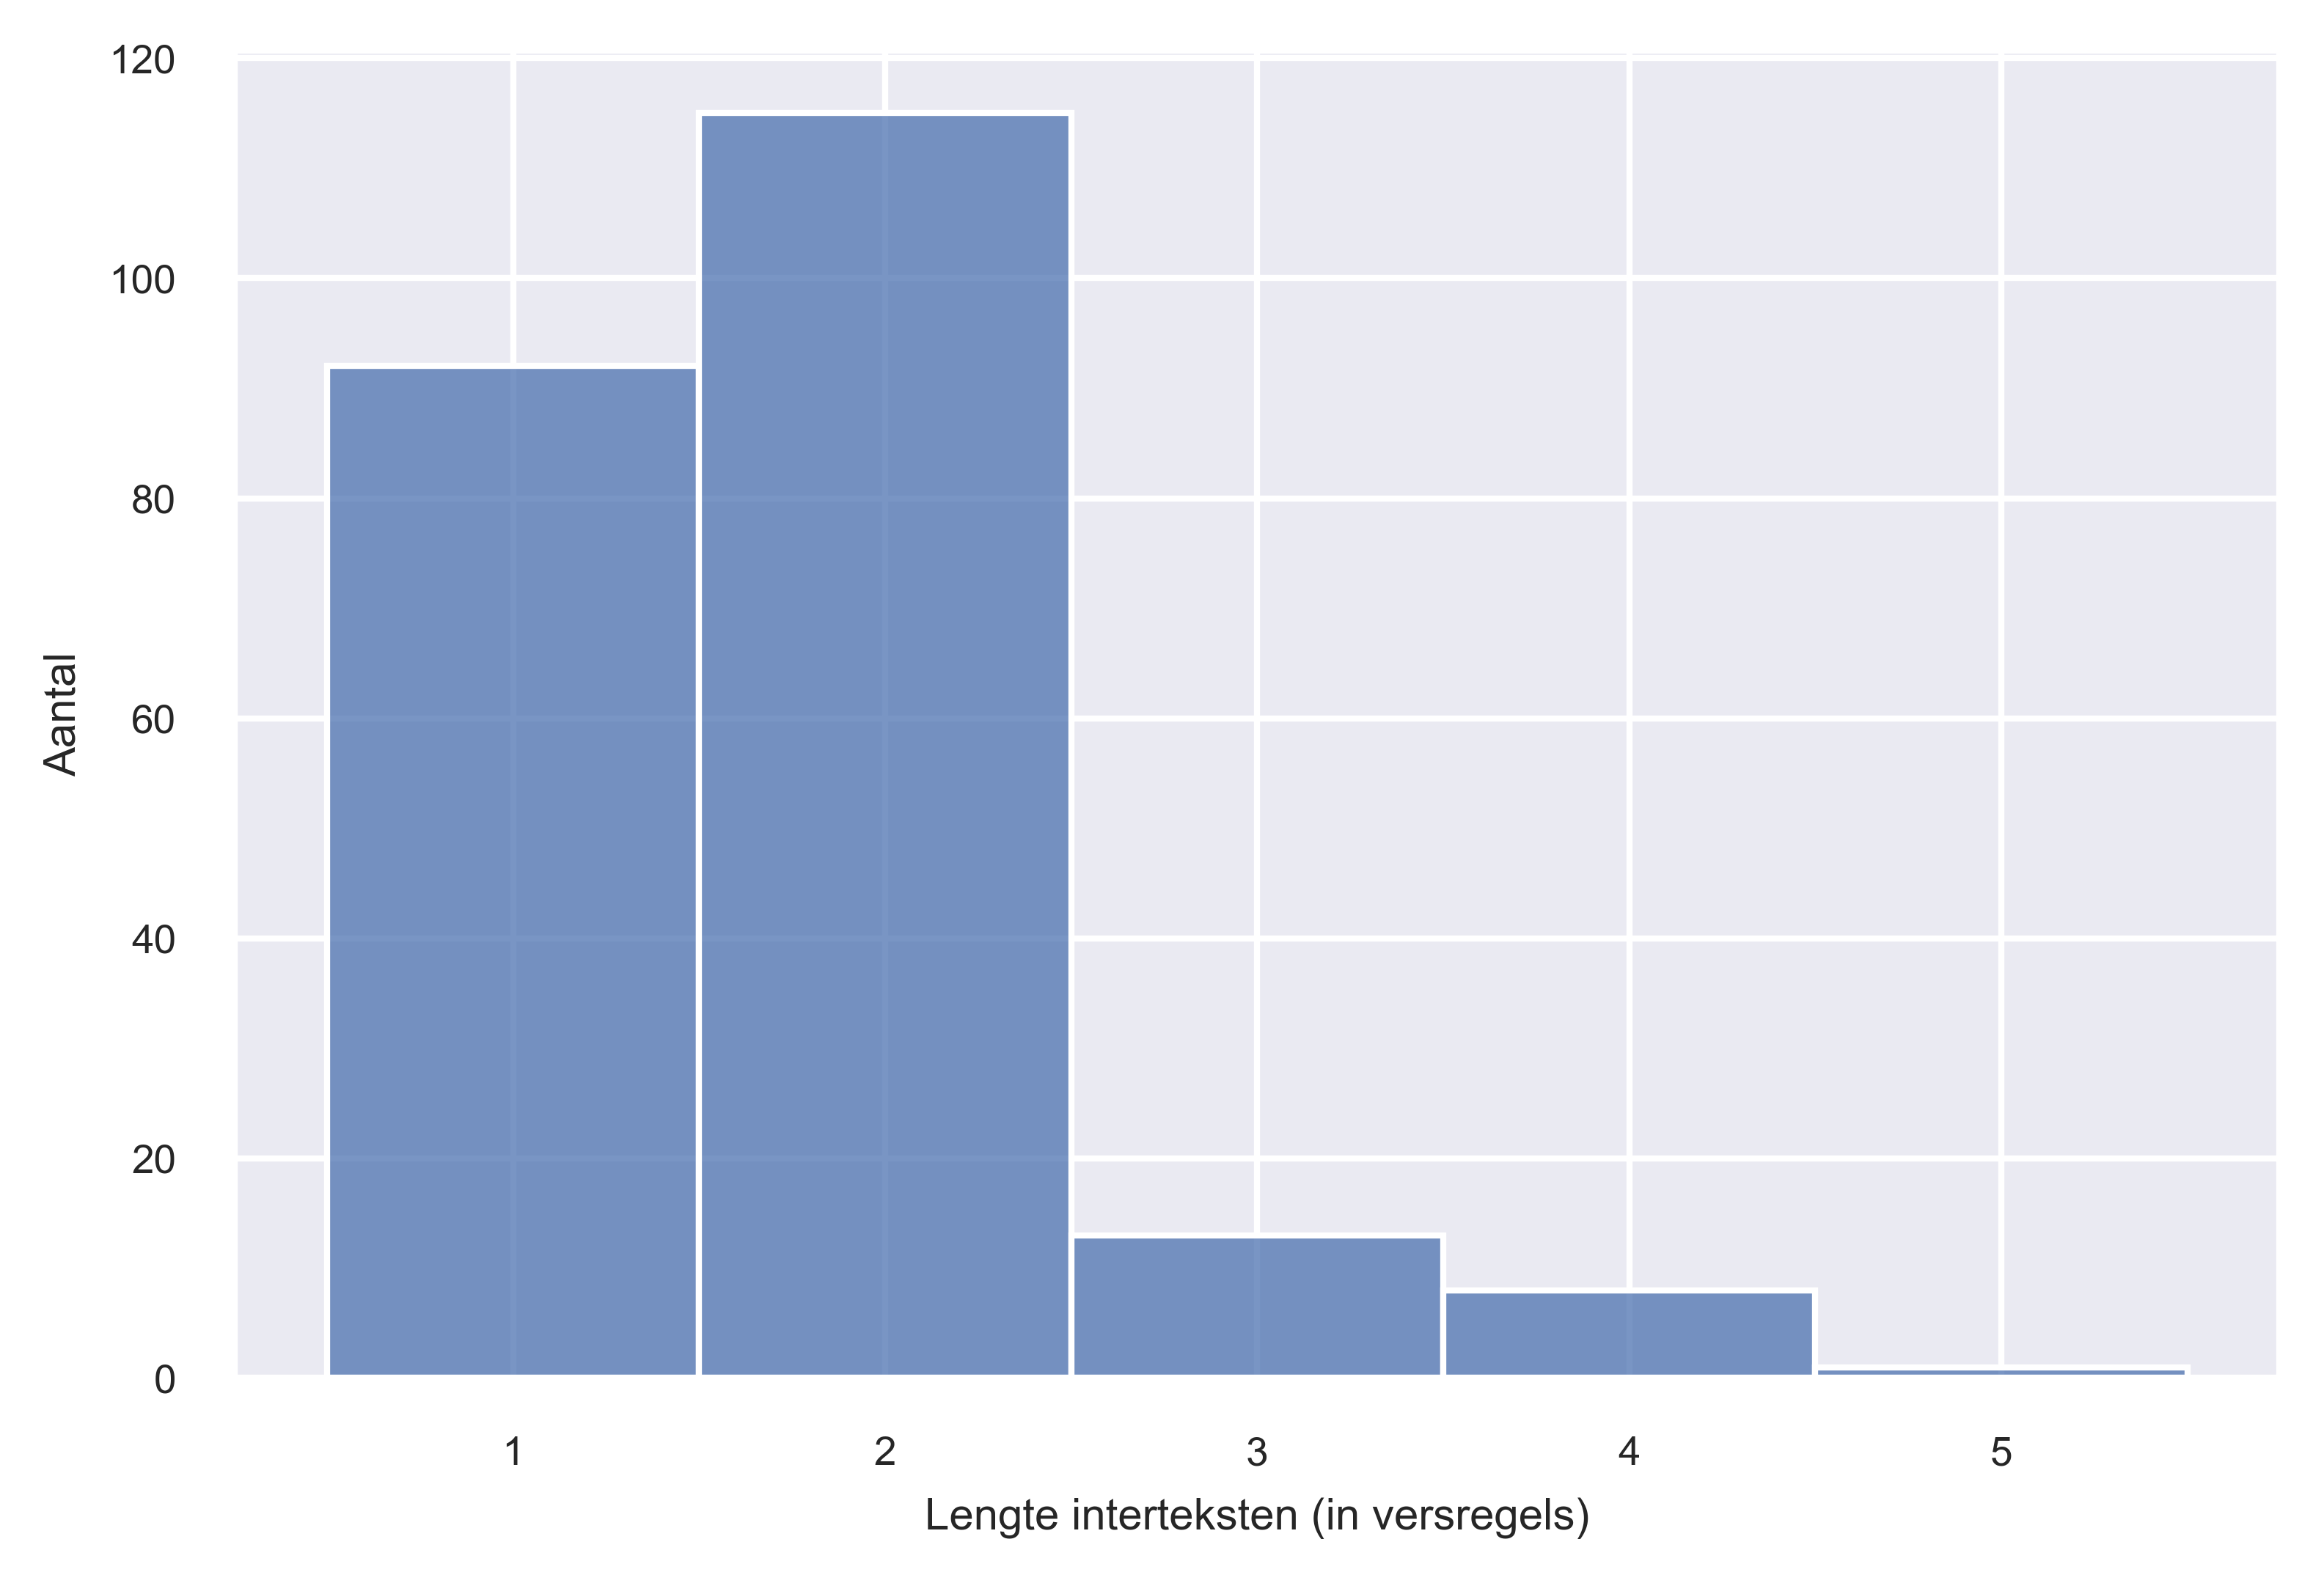

In [34]:
sb.histplot(data=intertexts, x="verse-length", discrete=True)
plt.xlabel('Lengte interteksten (in versregels)')
plt.ylabel('Aantal')
plt.savefig(f'{fig_dir}/intertext_dist.png');

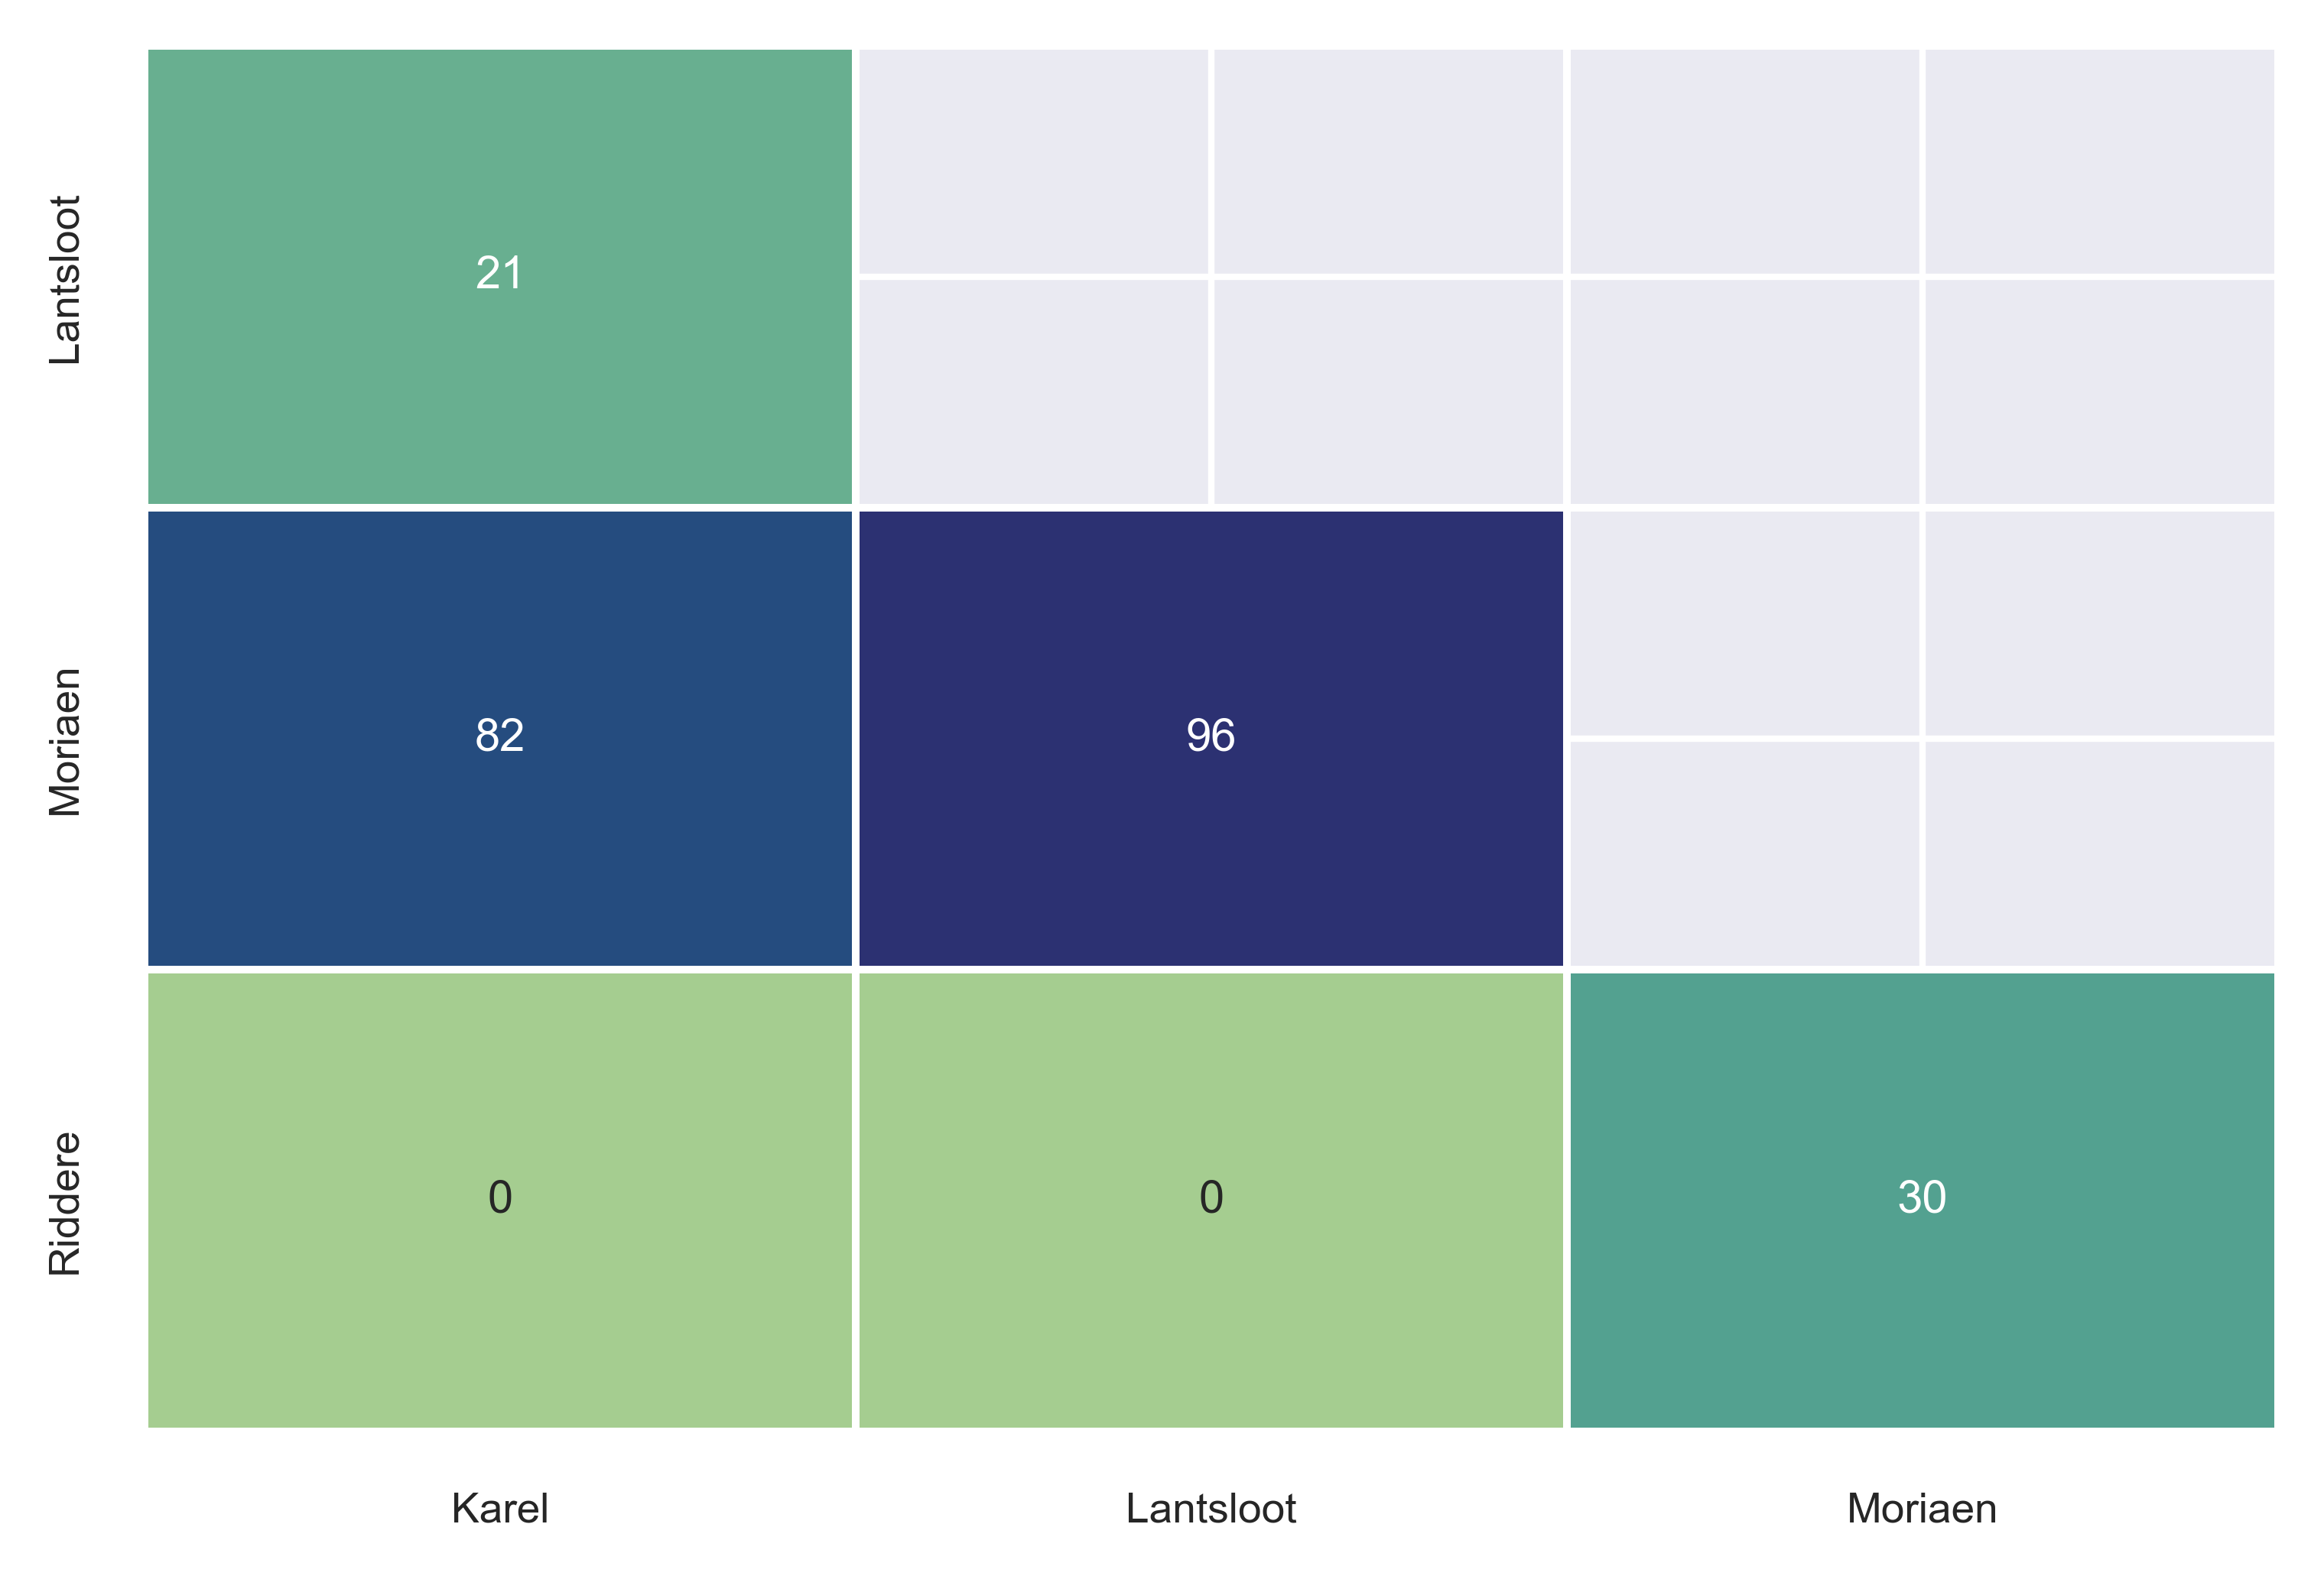

In [35]:
titles = sorted(set(intertexts['source'].tolist() + intertexts['target'].tolist()))
counts = np.zeros((len(titles), len(titles)))
for _, row in intertexts.iterrows():
    counts[titles.index(row['source']), titles.index(row['target'])] += 1
    counts[titles.index(row['target']), titles.index(row['source'])] += 1
np.fill_diagonal(counts, np.nan)
counts[np.triu_indices(4)] = np.nan
titles = [t.split()[0] for t in titles]
counts = pd.DataFrame(counts, columns=titles, index=titles)
counts = counts.iloc[1:, :-1]
ax = sb.heatmap(counts, annot=True, cmap='crest', cbar=False, linewidths=1, linecolor='white')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.savefig(f'{fig_dir}/intertext_links.png');

#### Load metadata

In [36]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
239,strofische_gedichten,Strofische gedichten,Hadewijch,1350.0,cdrom-mnl,1340-1360,Lyriek,NaN,NaN
94,jonathas_ende_rosafiere,Jonathas ende Rosafiere,NaN,1500.0,cdrom-mnl,1490-1510,Epiek,Ridder,NaN
221,spiegel_historiael__2_fragm_brg,Spiegel historiael (P2),Philip Utenbroeke,1400.0,cdrom-mnl,1390-1410,Epiek,Historiografie,NaN
261,van_der_wive_wonderlijcheit_lang,Van der wive wonderlijcheit (lange versie),NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Didactiek,NaN
37,collectief_lunarium_ii,Collectief lunarium II,NaN,1435.0,cdrom-mnl,1434-1436,Epiek,Didactiek,NaN
149,ongeidentificeerd_1,Ongeïdentificeerd (1),NaN,1225.0,cdrom-mnl,1200-1250,Epiek,Ridder,NaN
12,beerte_metten_breden_voeten,Beerte metten breden voeten,NaN,1400.0,cdrom-mnl,1375-1425,Epiek,Karel,NaN
106,leven_van_sint_trudo,Leven van Sint Trudo (berijming),NaN,1400.0,cdrom-mnl,1390-1410,Epiek,Heiligenleven,NaN
35,collectief_lunarium_iii,Collectief lunarium III,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Religie,NaN


In [37]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [38]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [39]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:11<00:00, 17.28it/s]


In [40]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
340350,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2
340386,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47
340398,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5
340437,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8
340465,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10
340467,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
340540,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
340564,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16
340630,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
340644,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19


In [41]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=10000, min_df=2,
                      tokenizer=tokenizer, token_pattern=None)
X = vec.fit_transform(df['lemmas'])
X.shape

(925350, 10000)

In [42]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

In [43]:
df = add_rhyme_column(df)
df.head()
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
340350,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
340386,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
340398,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5,groot genoot
340437,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8,achter lachter
340465,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
340467,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
340540,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15,weten list
340564,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16,land onbekend
340630,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17,wel el
340644,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19,zin in


## Nearest neighbors

In [44]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.15):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [45]:
nearest_df = nearest_verses('Moriaen', 'Lantsloot van der Haghedochte',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.to_excel('../figures/mor-ele-selection.xlsx')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
1699,Des men drinken mochte ende eten / Ende alles leets daer bi vergeten,Dat men drinken mocht ende eten / Ende leets bi vergheten,dat men drinken mogen en eten / en al leed daar bij vergeten,dat men drinken mogen en eten / en leed bij vergeten,Moriaen,Lantsloot van der Haghedochte,lan-ele-62,lan-ele-62,0.028855
886,Die es der werelt toeverlaet / Die late mi noch mine mesdaet,Die es der warelt toeuerlaet / Die late mj mine mesdaet,die zijn de wereld toeverlaat / die laten ik nog mijn misdaad,die zijn de wereld toeverlaat / die laten ik mijn misdaad,Moriaen,Lantsloot van der Haghedochte,lan-ele-52,lan-ele-52,0.046525
1795,Ende drogen des over een / Die daer waren in den steen,Si hebben gedreghen ouer een / Die daer sijn in den steen,en dragen de over een / die daar zijn in de steen,zij hebben dragen over een / die daar zijn in de steen,Moriaen,Lantsloot van der Haghedochte,mor-ele-40,mor-ele-40,0.061468
859,Alse lange alsi mochte leven / Getrouwelike sonder begeven,Also langhe alsic sal leuen / Ghetrouwelike sonder begheuen,alzo lang als zij mogen leven / getrouwelijk zonder begeven,alzo lang als ik zullen leven / getrouwelijk zonder begeven,Moriaen,Lantsloot van der Haghedochte,None,None,0.068831
1147,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,Moriaen,Lantsloot van der Haghedochte,mor-ele-49,mor-ele-49,0.070079
2328,Tes icker weder come toe / Ende ic sal u vort secgen hoe,Des icker weder come toe / Ende sal v segghen hoe,dat ik er weder komen te / en ik zullen gij voort zeggen hoe,dat ik er weder komen te / en zullen gij zeggen hoe,Moriaen,Lantsloot van der Haghedochte,None,None,0.087830
323,Nu ne licgic nembermee / Boven enen nacht of twee,Dat hine laghe nemmermee / Bouen ere nacht ofte twee,nu ne ik liggen nimmermee / boven een nacht of twee,dat hij hij liggen nimmermee / boven een nacht of twee,Moriaen,Lantsloot van der Haghedochte,lan-ele-38,lan-ele-38,0.094798
957,Ende vrachden hem om niemare / Ofter enech ridder leden ware,Ende si vragheden hem om niemare / Of daer enich ridder leden ware,en vragen hij om nieuwmaar / af enig ridder lijden zijn,en zij vragen hij om nieuwmaar / of daar enig ridder lijden zijn,Moriaen,Lantsloot van der Haghedochte,None,lan-ele-36,0.104913
1609,Ende alse Walewein hadde verwonnen / Ende hem God hadde geonnen,Doe lantsloot hadde verwonnen / Des hem god hadde gheonnen,en als n(prop) hebben verwinnen / en hij god hebben gene,toen n(prop) hebben verwinnen / dat hij god hebben gene,Moriaen,Lantsloot van der Haghedochte,None,None,0.112968
1966,Der doet hi hadde daer menegen vrient / Die sere clageden haren toren,Hi hadde nochtan meneghen vrient / Die sere clagheden haren toren,de dood hij hebben daar menig vriend / die zeer klagen haar toorn,hij hebben nochtan menig vriend / die zeer klagen haar toorn,Moriaen,Lantsloot van der Haghedochte,lan-ele-56,lan-ele-56,0.117553


#### Intermezzo: voorbeeld TF-IDF

In [46]:
small = df[df['title'] == 'Karel ende Elegast'].iloc[[20]]
small

,title,tokens,lemmas,intertext,rhyme
340358,Karel ende Elegast,Wapent v ende vaert stelen / God die hiet mi v beuelen,wapenen gij en varen stelen / n(prop) die heten ik gij bevelen,None,stelen bevelen


In [47]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, norm='l1',
                      token_pattern=None, use_idf=False).fit(df['lemmas'])

In [48]:
small_vocab = set(' '.join(small['lemmas']).split())
print(small_vocab)
vocab = vec.get_feature_names_out()
small_vocab = sorted({v for v in small_vocab if v in vocab})
print(small_vocab)

{'en', 'die', 'bevelen', 'ik', 'gij', 'stelen', 'varen', 'heten', 'wapenen', '/', 'n(prop)'}
['bevelen', 'die', 'en', 'gij', 'heten', 'ik', 'n(prop)', 'stelen', 'varen', 'wapenen']


In [49]:
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
rel_freq = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rel. freq.'])
rel_freq

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909


In [50]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      token_pattern=None,
                      tokenizer=tokenizer, use_idf=True).fit(df['lemmas'])
small_x = vec.transform(small['lemmas']).toarray()
features = list(vec.get_feature_names_out())
idxs = [features.index(l) for l in small_vocab]
tfidf = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['TF-IDF'])
tfidf

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
TF-IDF,0.401369,0.160796,0.114561,0.39244,0.300772,0.168263,0.134101,0.469276,0.303691,0.443516


In [51]:
small_x = vec.transform(small['rhyme']).toarray()
rhyme = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Only rhyme'])
rhyme

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Only rhyme,0.649981,0.0,0.0,0.0,0.0,0.0,0.0,0.759951,0.0,0.0


In [52]:
small_x = vec.transform(small['lemmas']).toarray() + .15 * vec.transform(small['rhyme']).toarray()
rhyme_weight = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rhyme weight (.15)'])
rhyme_weight

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rhyme weight (.15),0.498866,0.160796,0.114561,0.39244,0.300772,0.168263,0.134101,0.583269,0.303691,0.443516


In [53]:
table = pd.concat((rel_freq, tfidf, rhyme, rhyme_weight))
table

,bevelen,die,en,gij,heten,ik,n(prop),stelen,varen,wapenen
Rel. freq.,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
TF-IDF,0.401369,0.160796,0.114561,0.392440,0.300772,0.168263,0.134101,0.469276,0.303691,0.443516
Only rhyme,0.649981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.759951,0.000000,0.000000
Rhyme weight (.15),0.498866,0.160796,0.114561,0.392440,0.300772,0.168263,0.134101,0.583269,0.303691,0.443516


#### Comparison of verses

In [54]:
targets = df.loc[[465393, 516416, 386910, 341364]]
targets

,title,tokens,lemmas,intertext,rhyme
465393,Moriaen,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,mor-ele-49,spoed goed
516416,Riddere metter mouwen,Maer dat was pine jegen spoet / Die porte hen nieman daer ontoet,maar dat zijn pijn jegen spoed / de poort zij niemand daar onttoen,None,spoed onttoen
386910,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,mor-ele-49,spoed goed
341364,Karel ende Elegast,Noch bi nachte noch bi daghe / Dats pine teghen spoet,nog bij nacht noch bij dag / dat zijn pijn tegen spoed,None,dag spoed


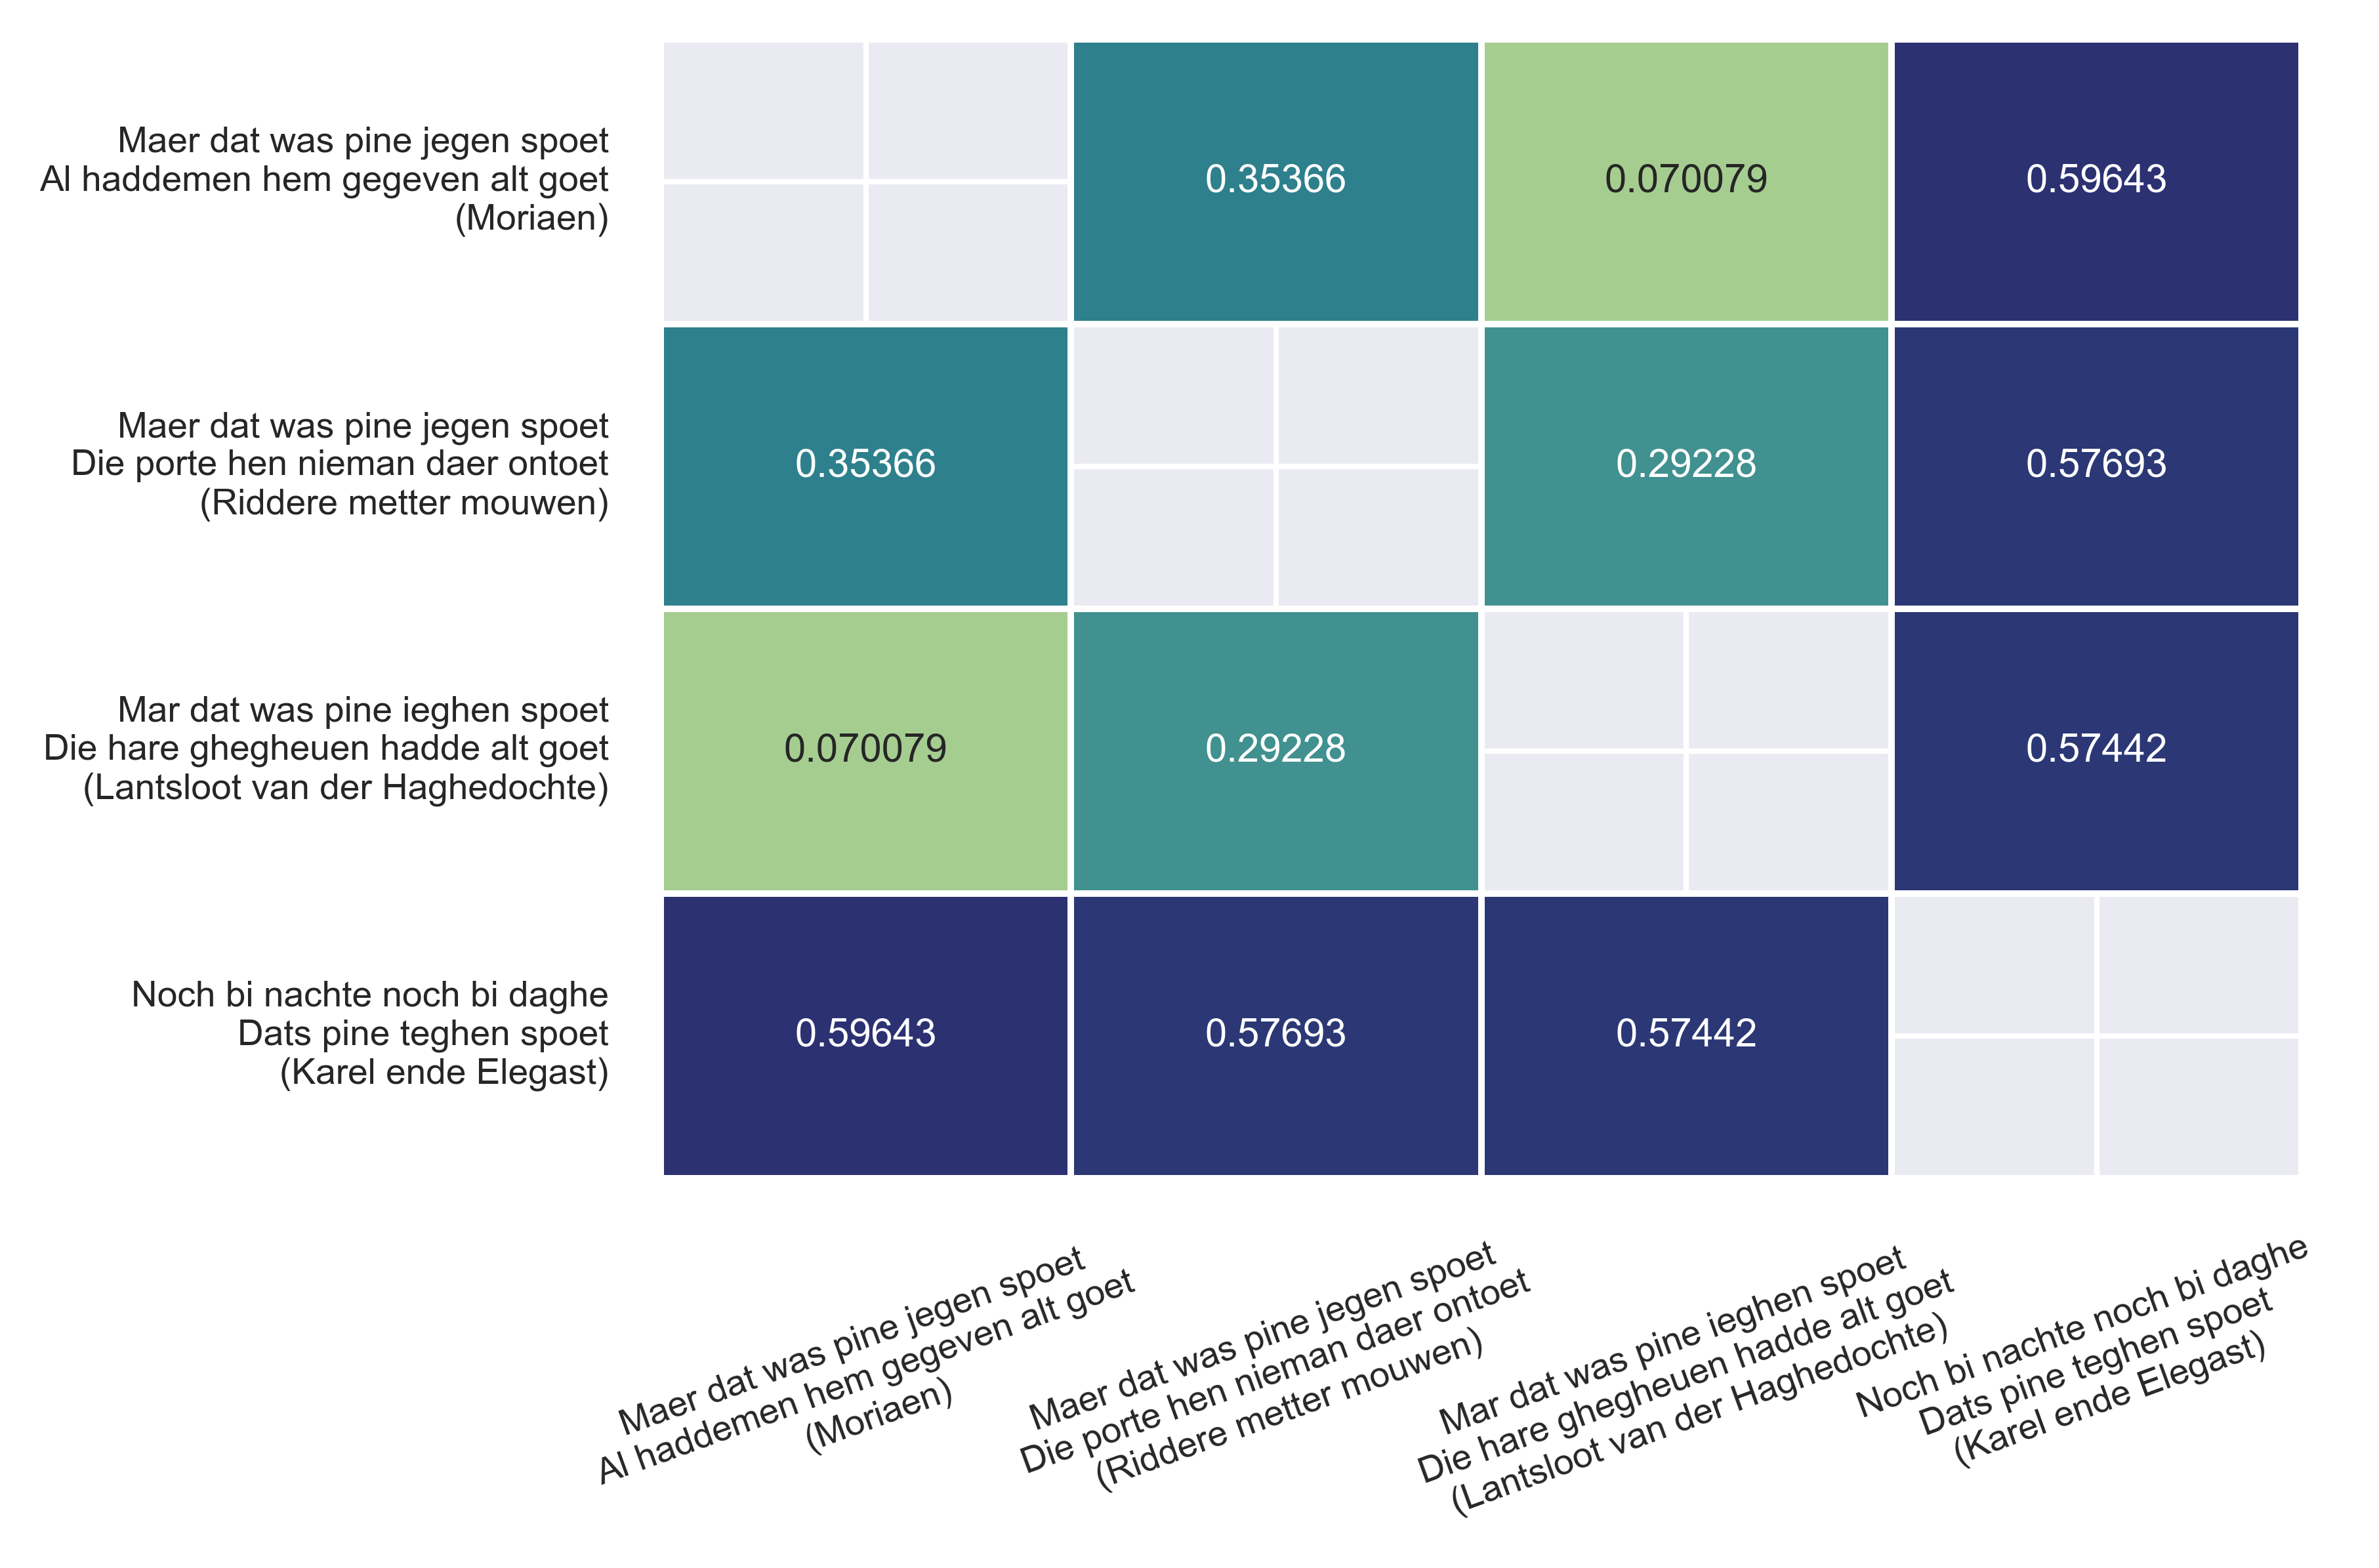

In [55]:
small_x = vec.transform(targets['lemmas']).toarray() + .15 * vec.transform(targets['rhyme']).toarray()
distances = squareform(pdist(small_x, metric='cosine'))
np.fill_diagonal(distances, np.nan)
labels = targets['tokens']
labels = [l.replace(' / ', '\n') for l in labels]
labels = [f'{label}\n({title})' for label, title in zip(labels, targets['title'])]
distances = pd.DataFrame(distances, index=labels, columns=labels)
sb.set(font_scale=.6)
ax = sb.heatmap(distances, annot=True, cmap='crest', cbar=False,
                linewidths=1, linecolor='white', fmt='.5g')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f'{fig_dir}/example_cosine.png');

## Precision-recall paradigm

In [56]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta.sample(5)

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks
131,mor-ele-29,Lantsloot van der Haghedochte,Wie hi was ende hoe hi hiet:,Moriaen,Wie hi was ende hoe hi hiet.,1,"Heeroma 1973b, Moriaen (II)",NaN
126,lan-ele-12,Lantsloot van der Haghedochte,Sal ic v der wareit lyen:,Moriaen,Salic v der waerheit lien.,1,"Heeroma 1973b, Moriaen (II)",NaN
41,mor-ele-42,Moriaen,Van al dien dat hen bedorste Ende dede hen halen sonder vorste.,Karel ende Elegast,Sulcke dinc als hem bedorste Doe sat hi op al sonder vorste,2,"Heeroma 1973a, Moriaen (I)",NaN
151,lan-ele-25,Lantsloot van der Haghedochte,Hier omme ben ic in dole Ende berne als een cole Toter wilen dat ic weet:,Moriaen,Doe worden die heren in dole Ende ontstaken als een cole Van rouwen dat si nine wisten.,3,"Heeroma 1973b, Moriaen (II)",NaN
134,lan-ele-14,Lantsloot van der Haghedochte,Si wilden hare nemen algader Dat hare bestarf van haren vader:,Moriaen,Dat haer verstarf van haren vader Het es ons ontwijst algader.,2,"Heeroma 1973b, Moriaen (II)",Overlaps with lan-ele-14


Determine rhyme weight with no restrictions on vocabulary size, except for `min_df=2`:

In [57]:
vec = TfidfVectorizer(max_features=None, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

In [58]:
def precision_recall(df, meta, vec, rhyme_weight=.15):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [59]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [60]:
distances = 1 - np.array(distances)

max(f1)=0.3525 @ theta=0.5001


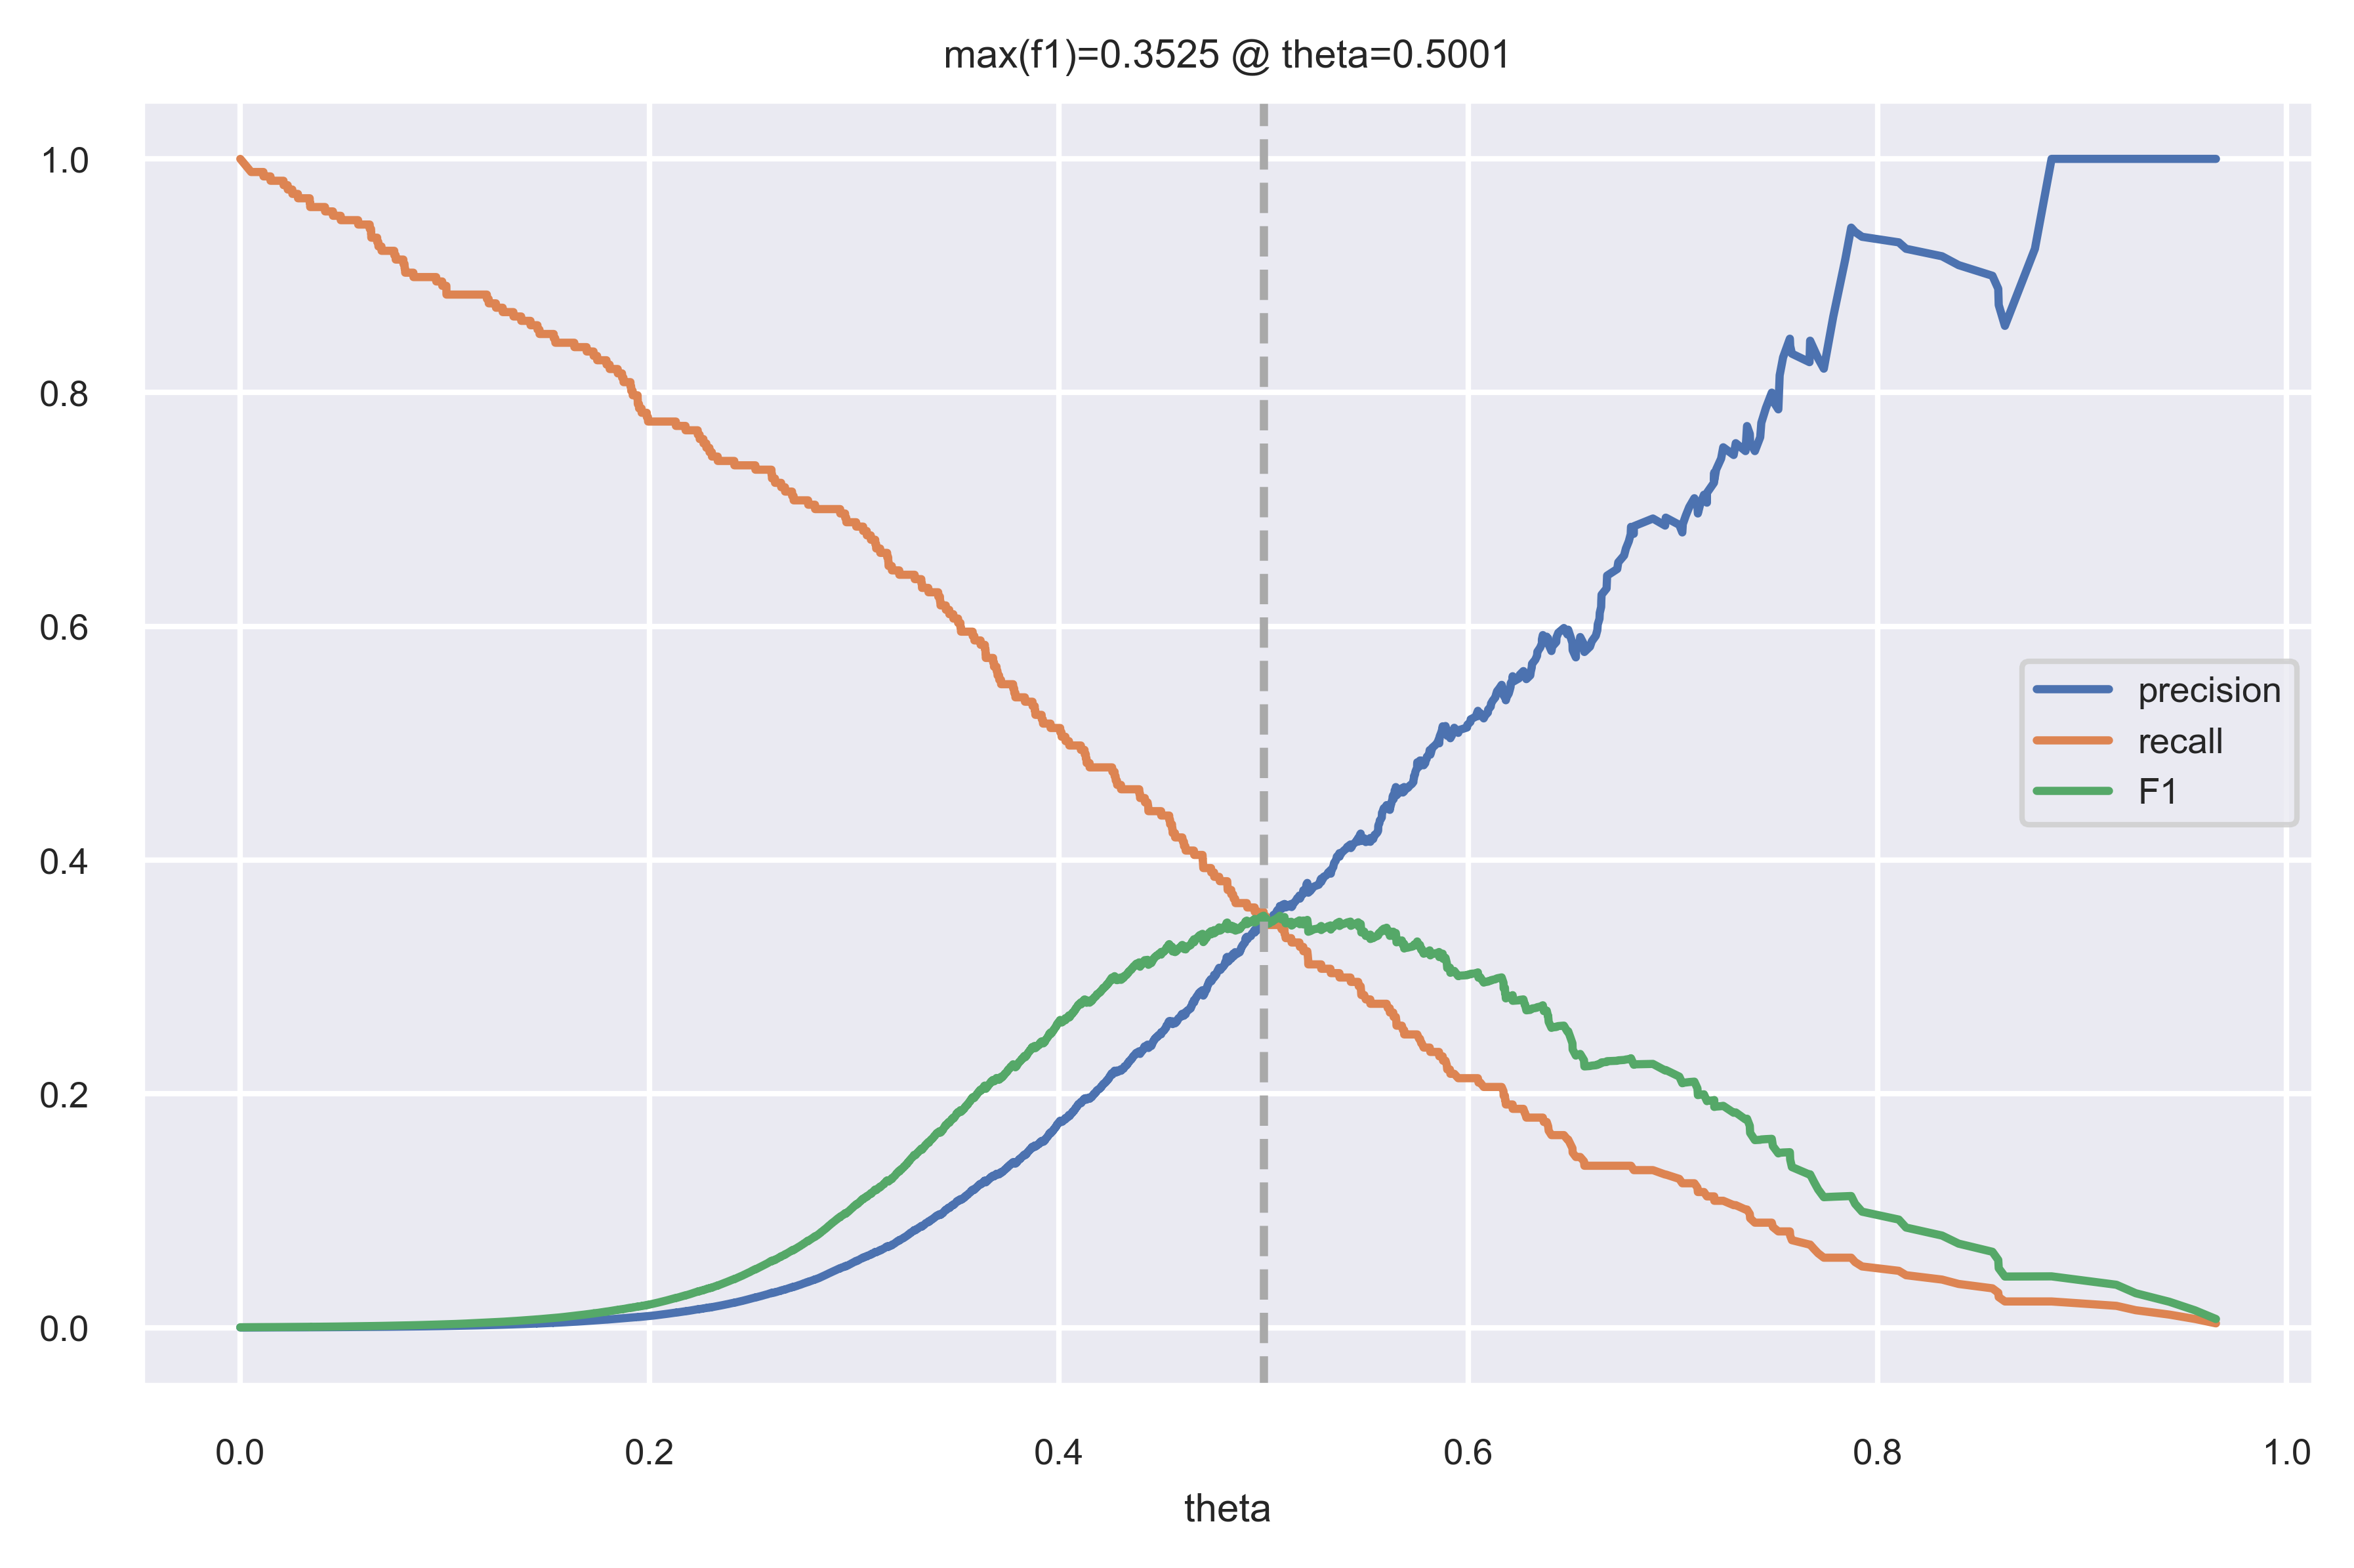

In [61]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout();

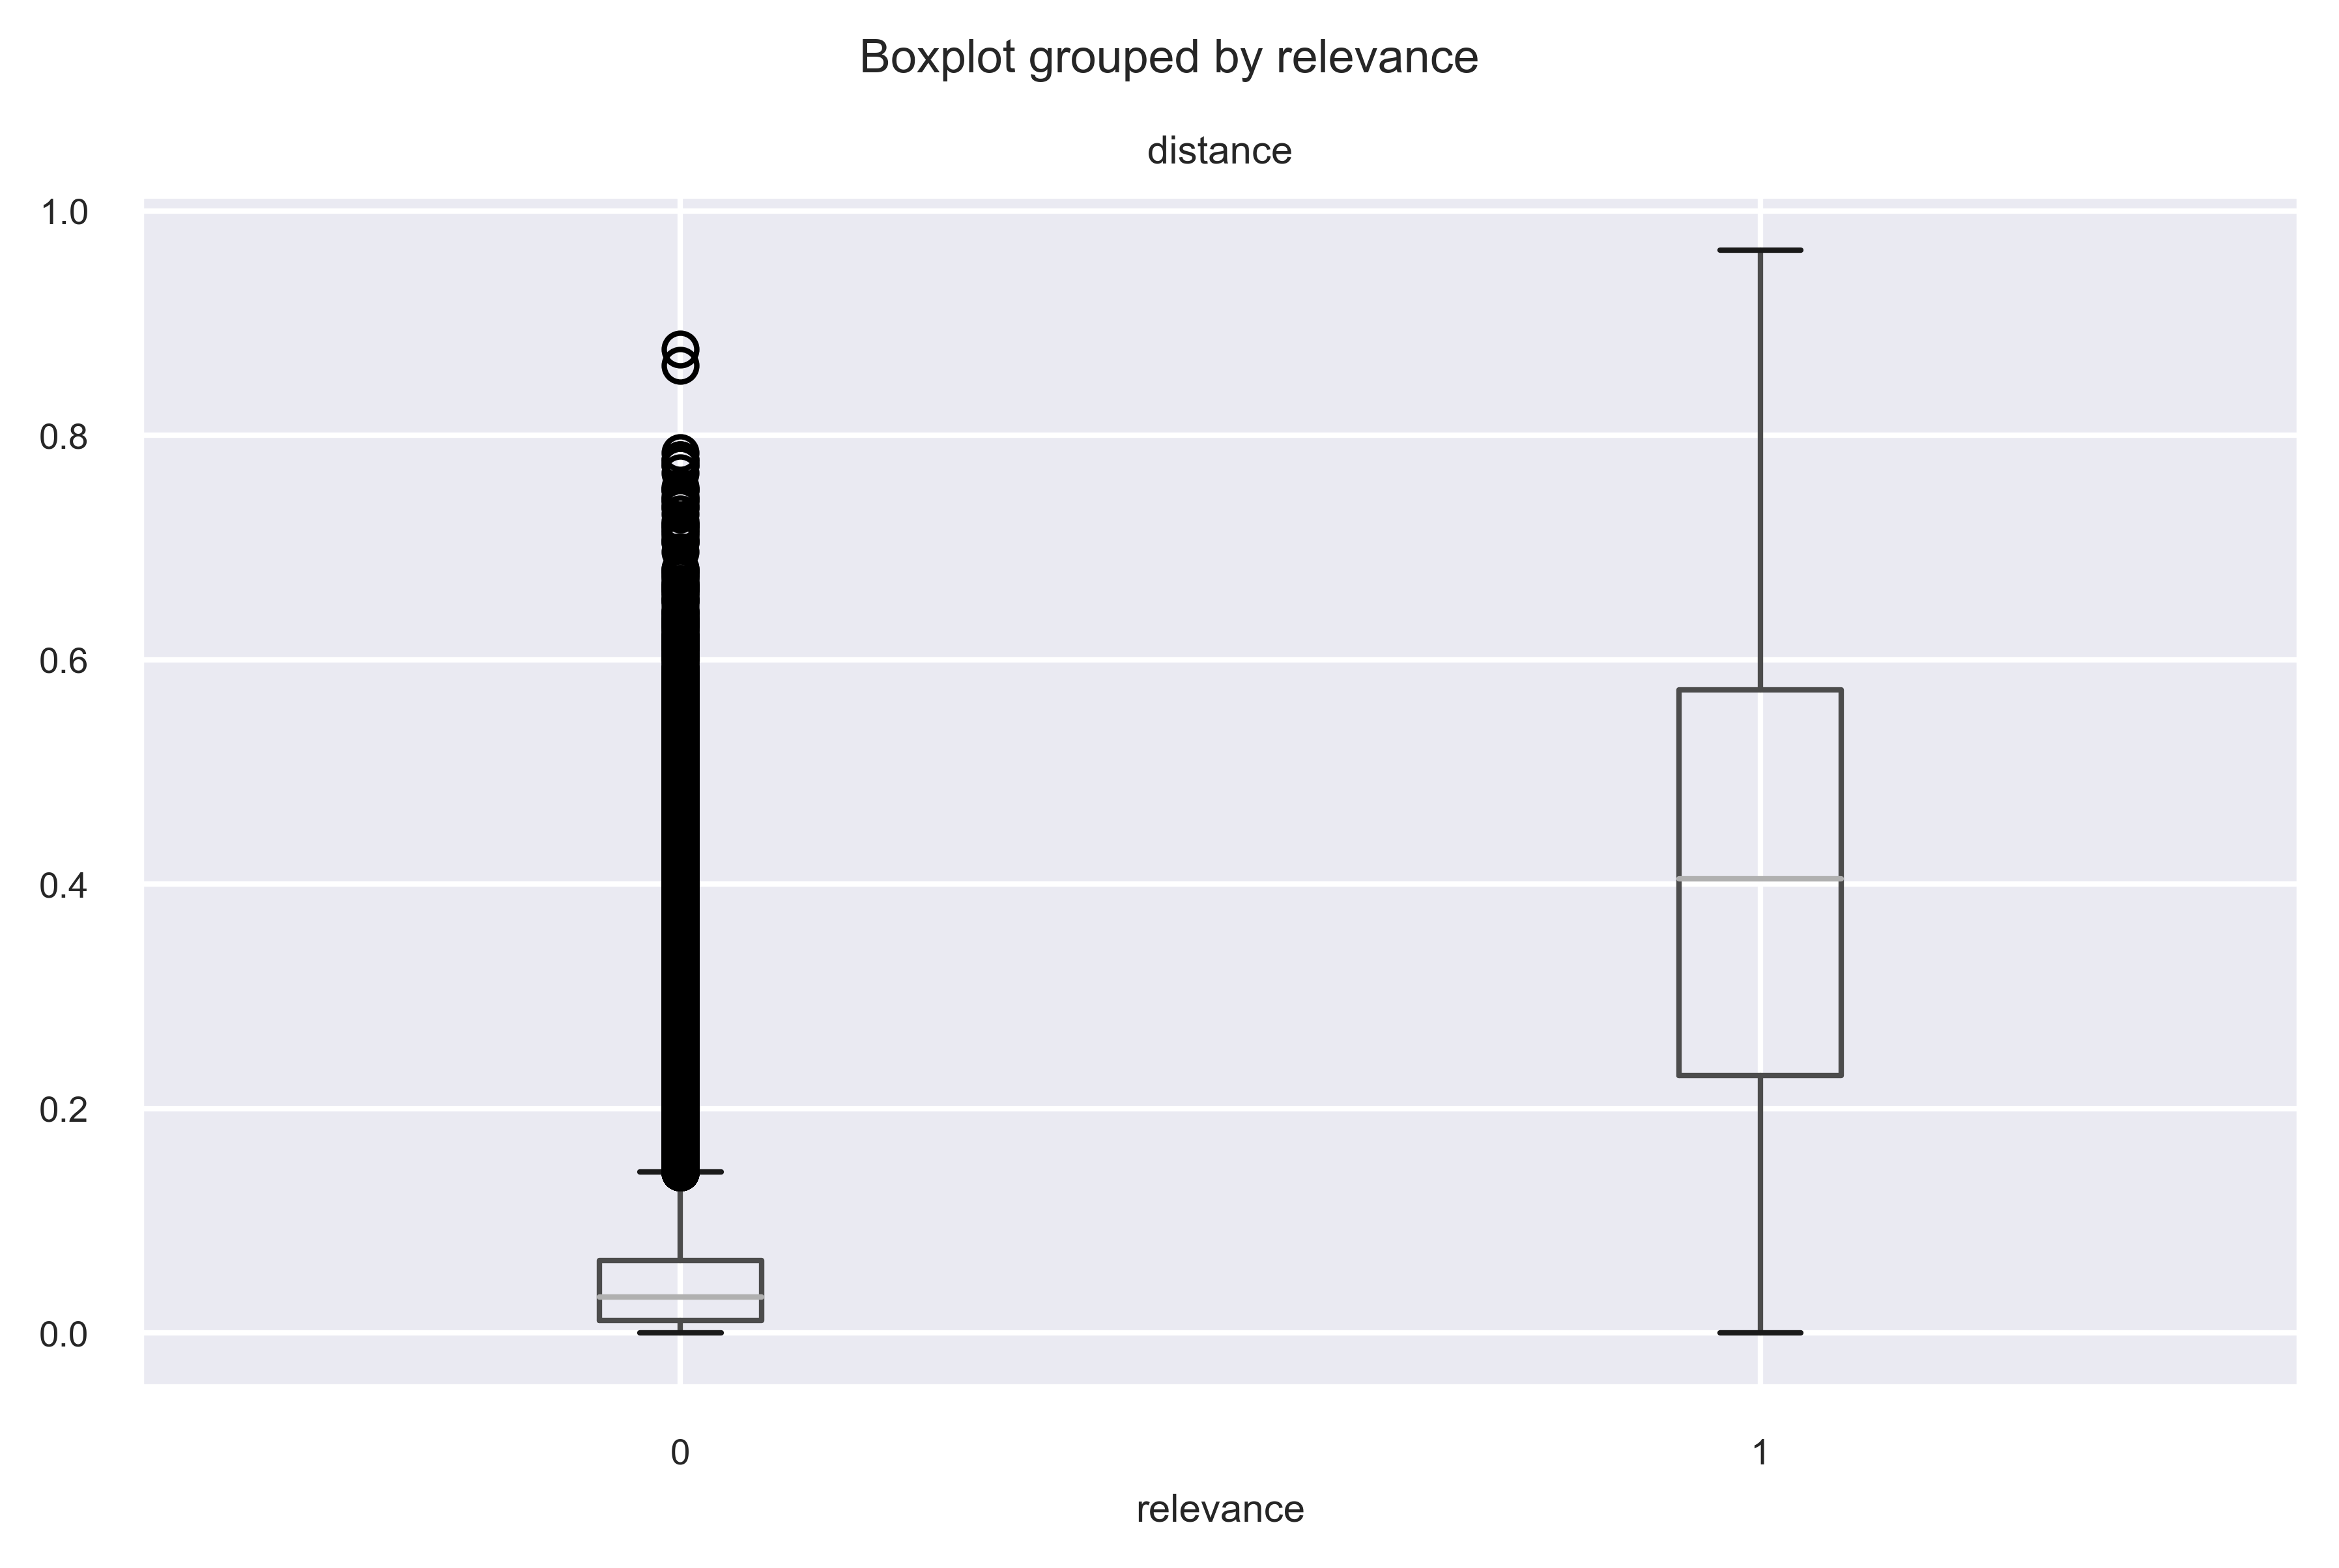

In [62]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [63]:
scores = []
# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:08<00:00,  3.77s/it]


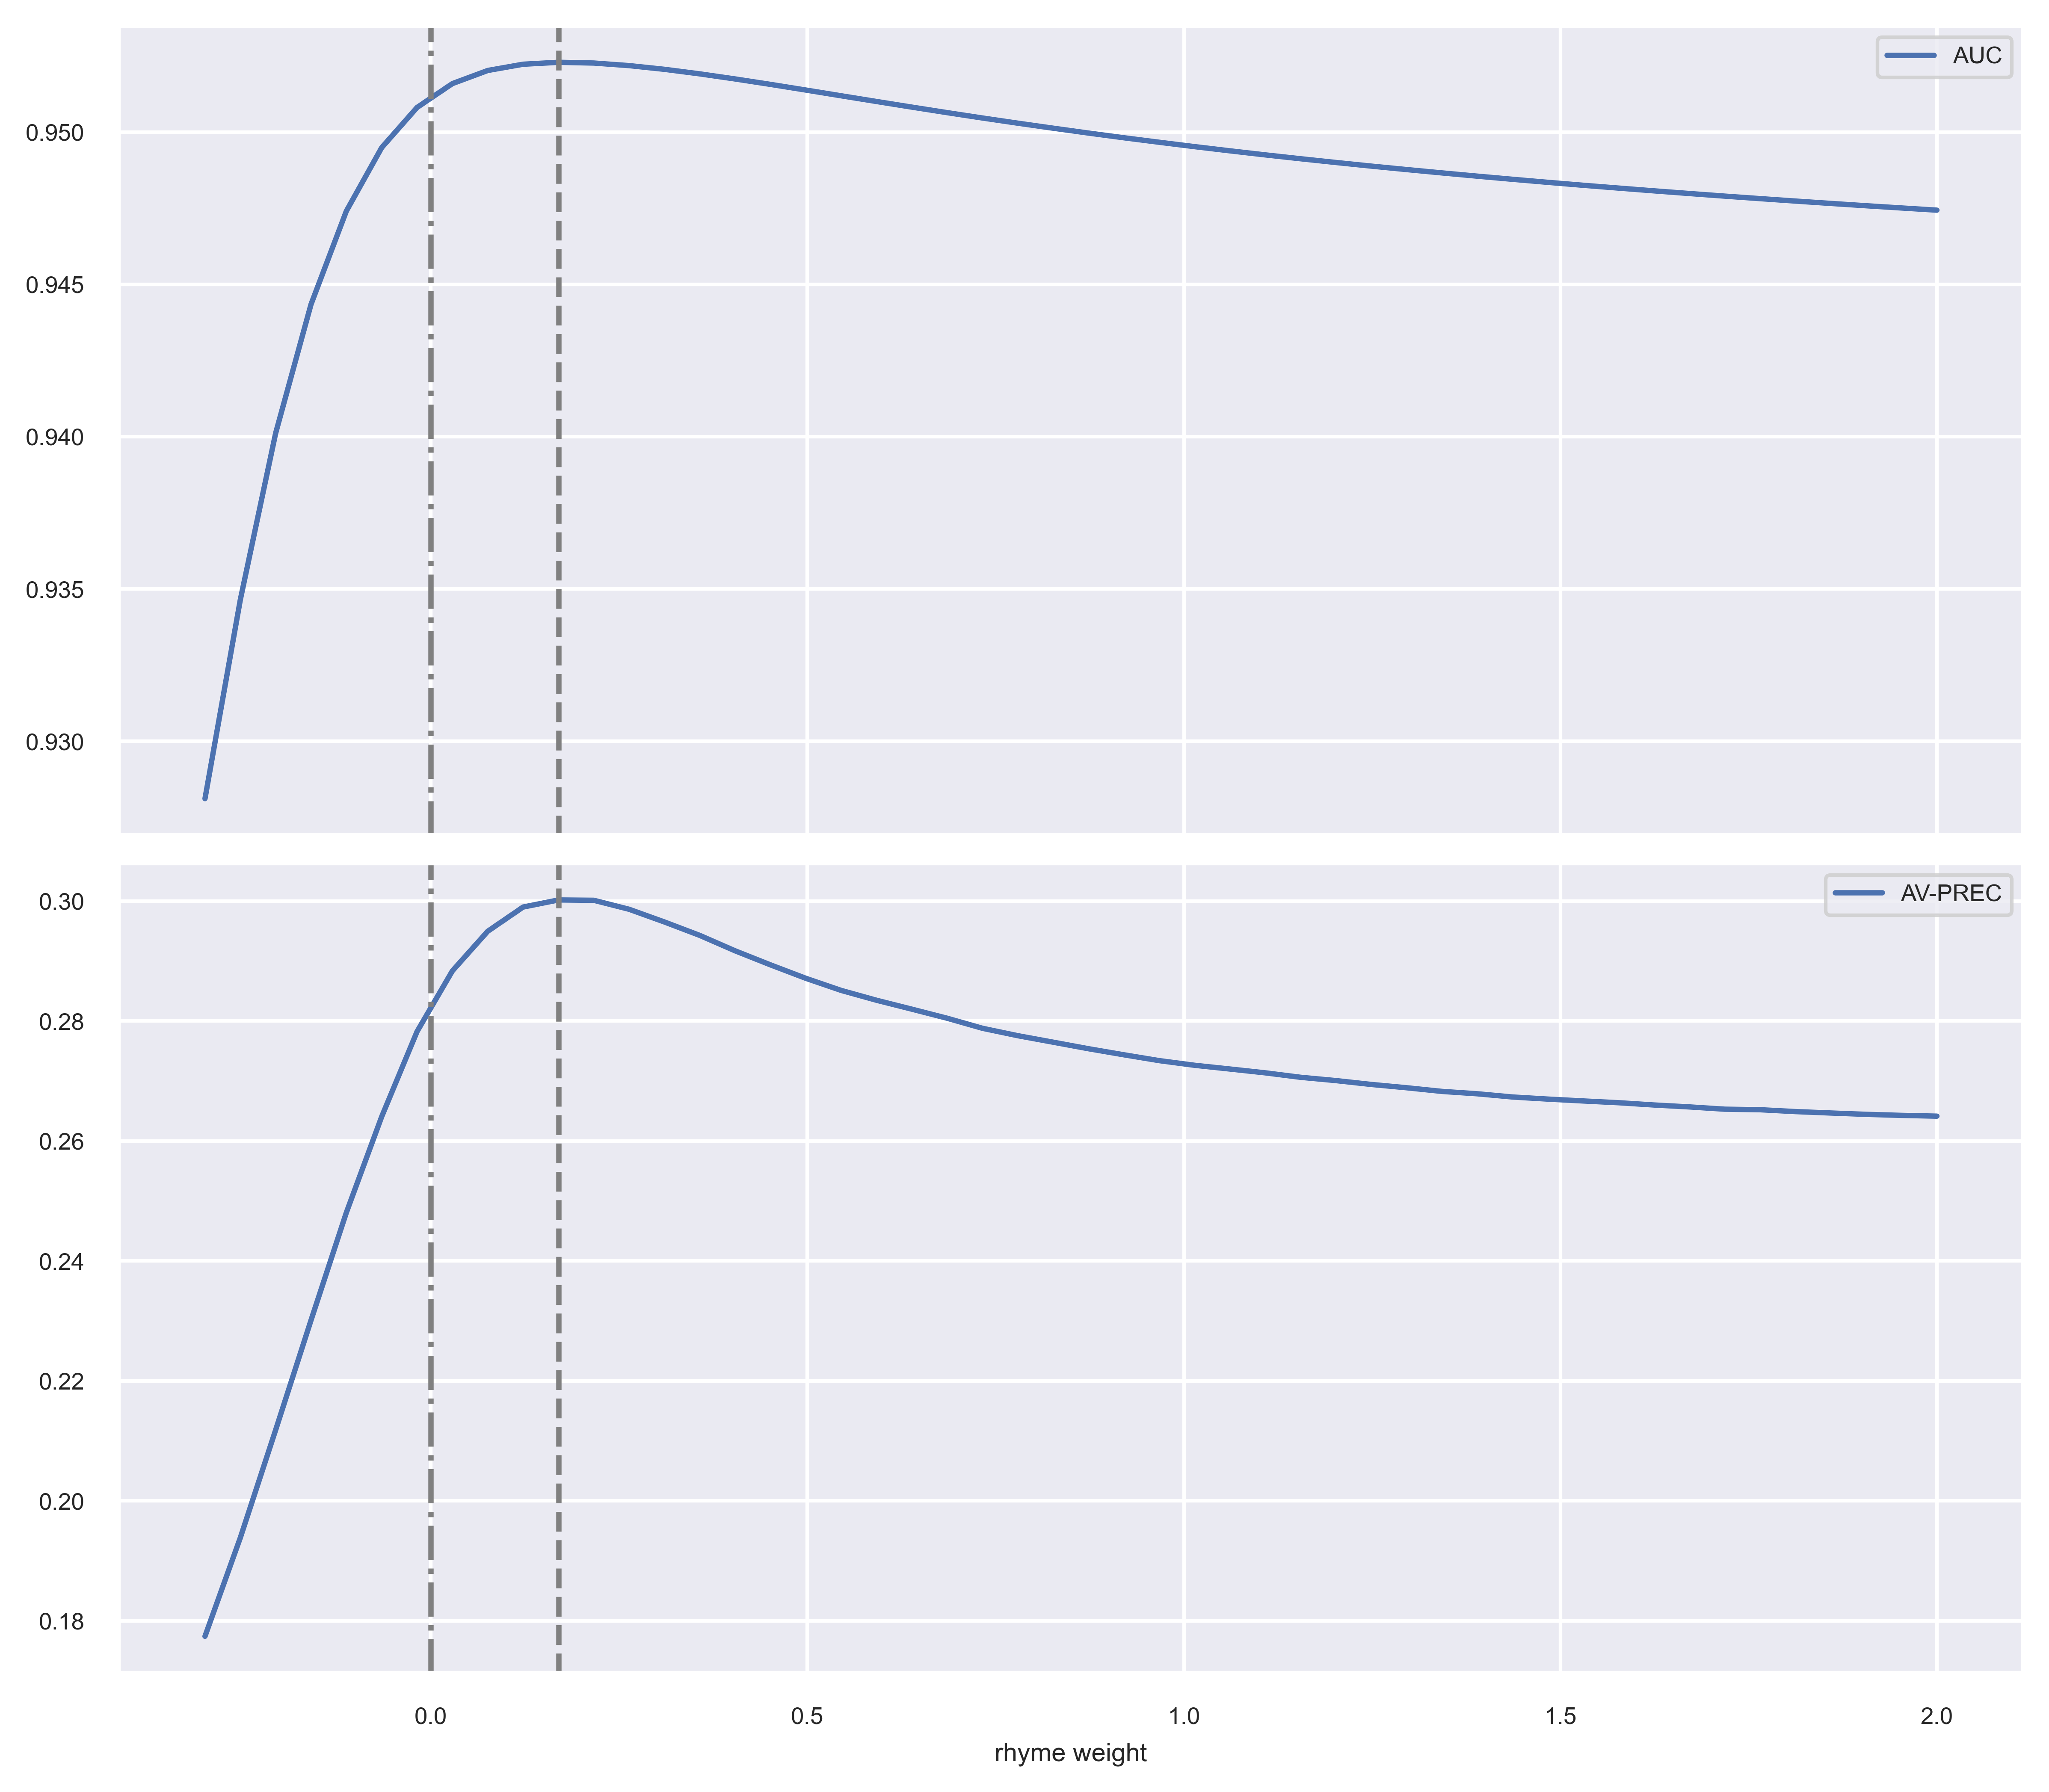

In [64]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(0, ls='-.', c='grey')
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(0, ls='-.', c='grey')
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey')
plt.tight_layout()
plt.savefig(f'{fig_dir}/rhyme_weight.png');

In [65]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [66]:
vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None,
                      min_df=2, max_features=None).fit(df['lemmas'])
print(len(vec.get_feature_names_out()))

40622


Vocabulary size for TF and TF-IDF:

In [67]:
scores = []

vocab_sizes = list(range(500, 41000, 500))
parametrizations = {
                    'TF-IDF': {'min_df': 2},
                    'TF': {'use_idf': False, 'min_df': 2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None, **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [45:29<00:00, 33.69s/it]


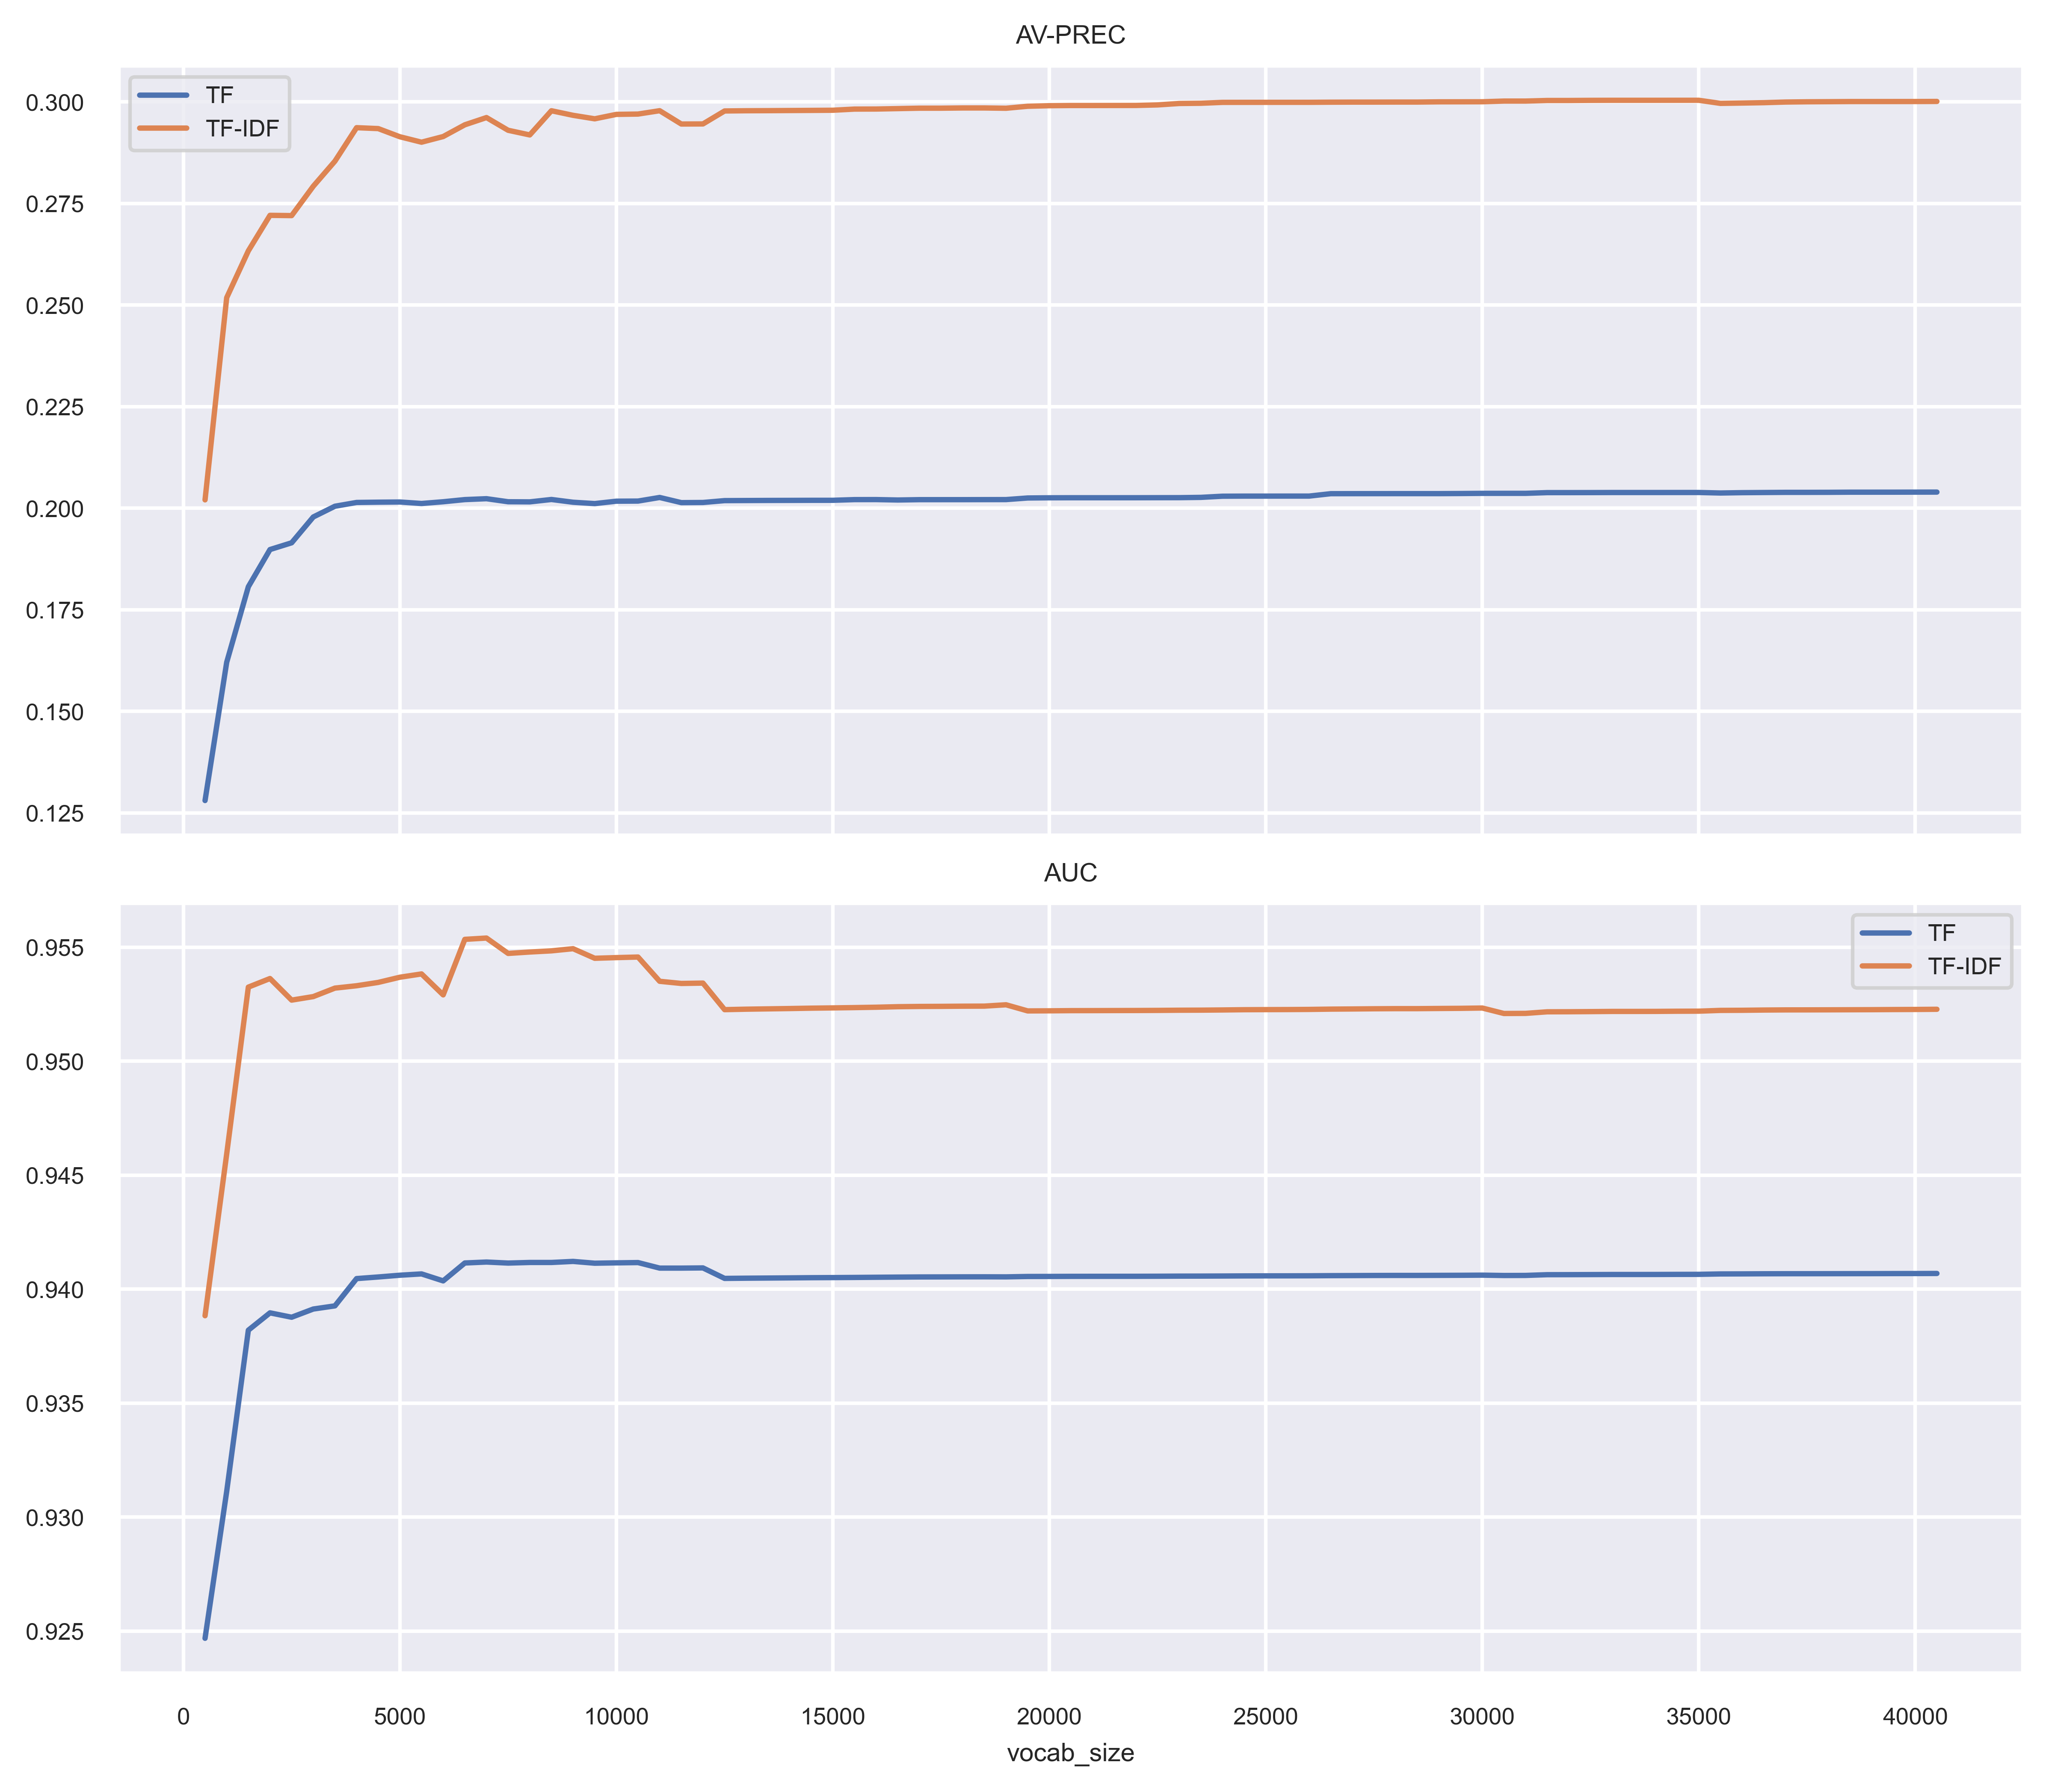

In [68]:
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC')

plt.tight_layout()
plt.savefig(f'{fig_dir}/vocab_size.png');

In [69]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']

param         TF-IDF  
vocab_size    7000    
AUC           0.955405
AV-PREC       0.296145
comb          0.282939
Name: 26, dtype: object

## Final threshold

max(f1)=0.3607 @ theta=0.578


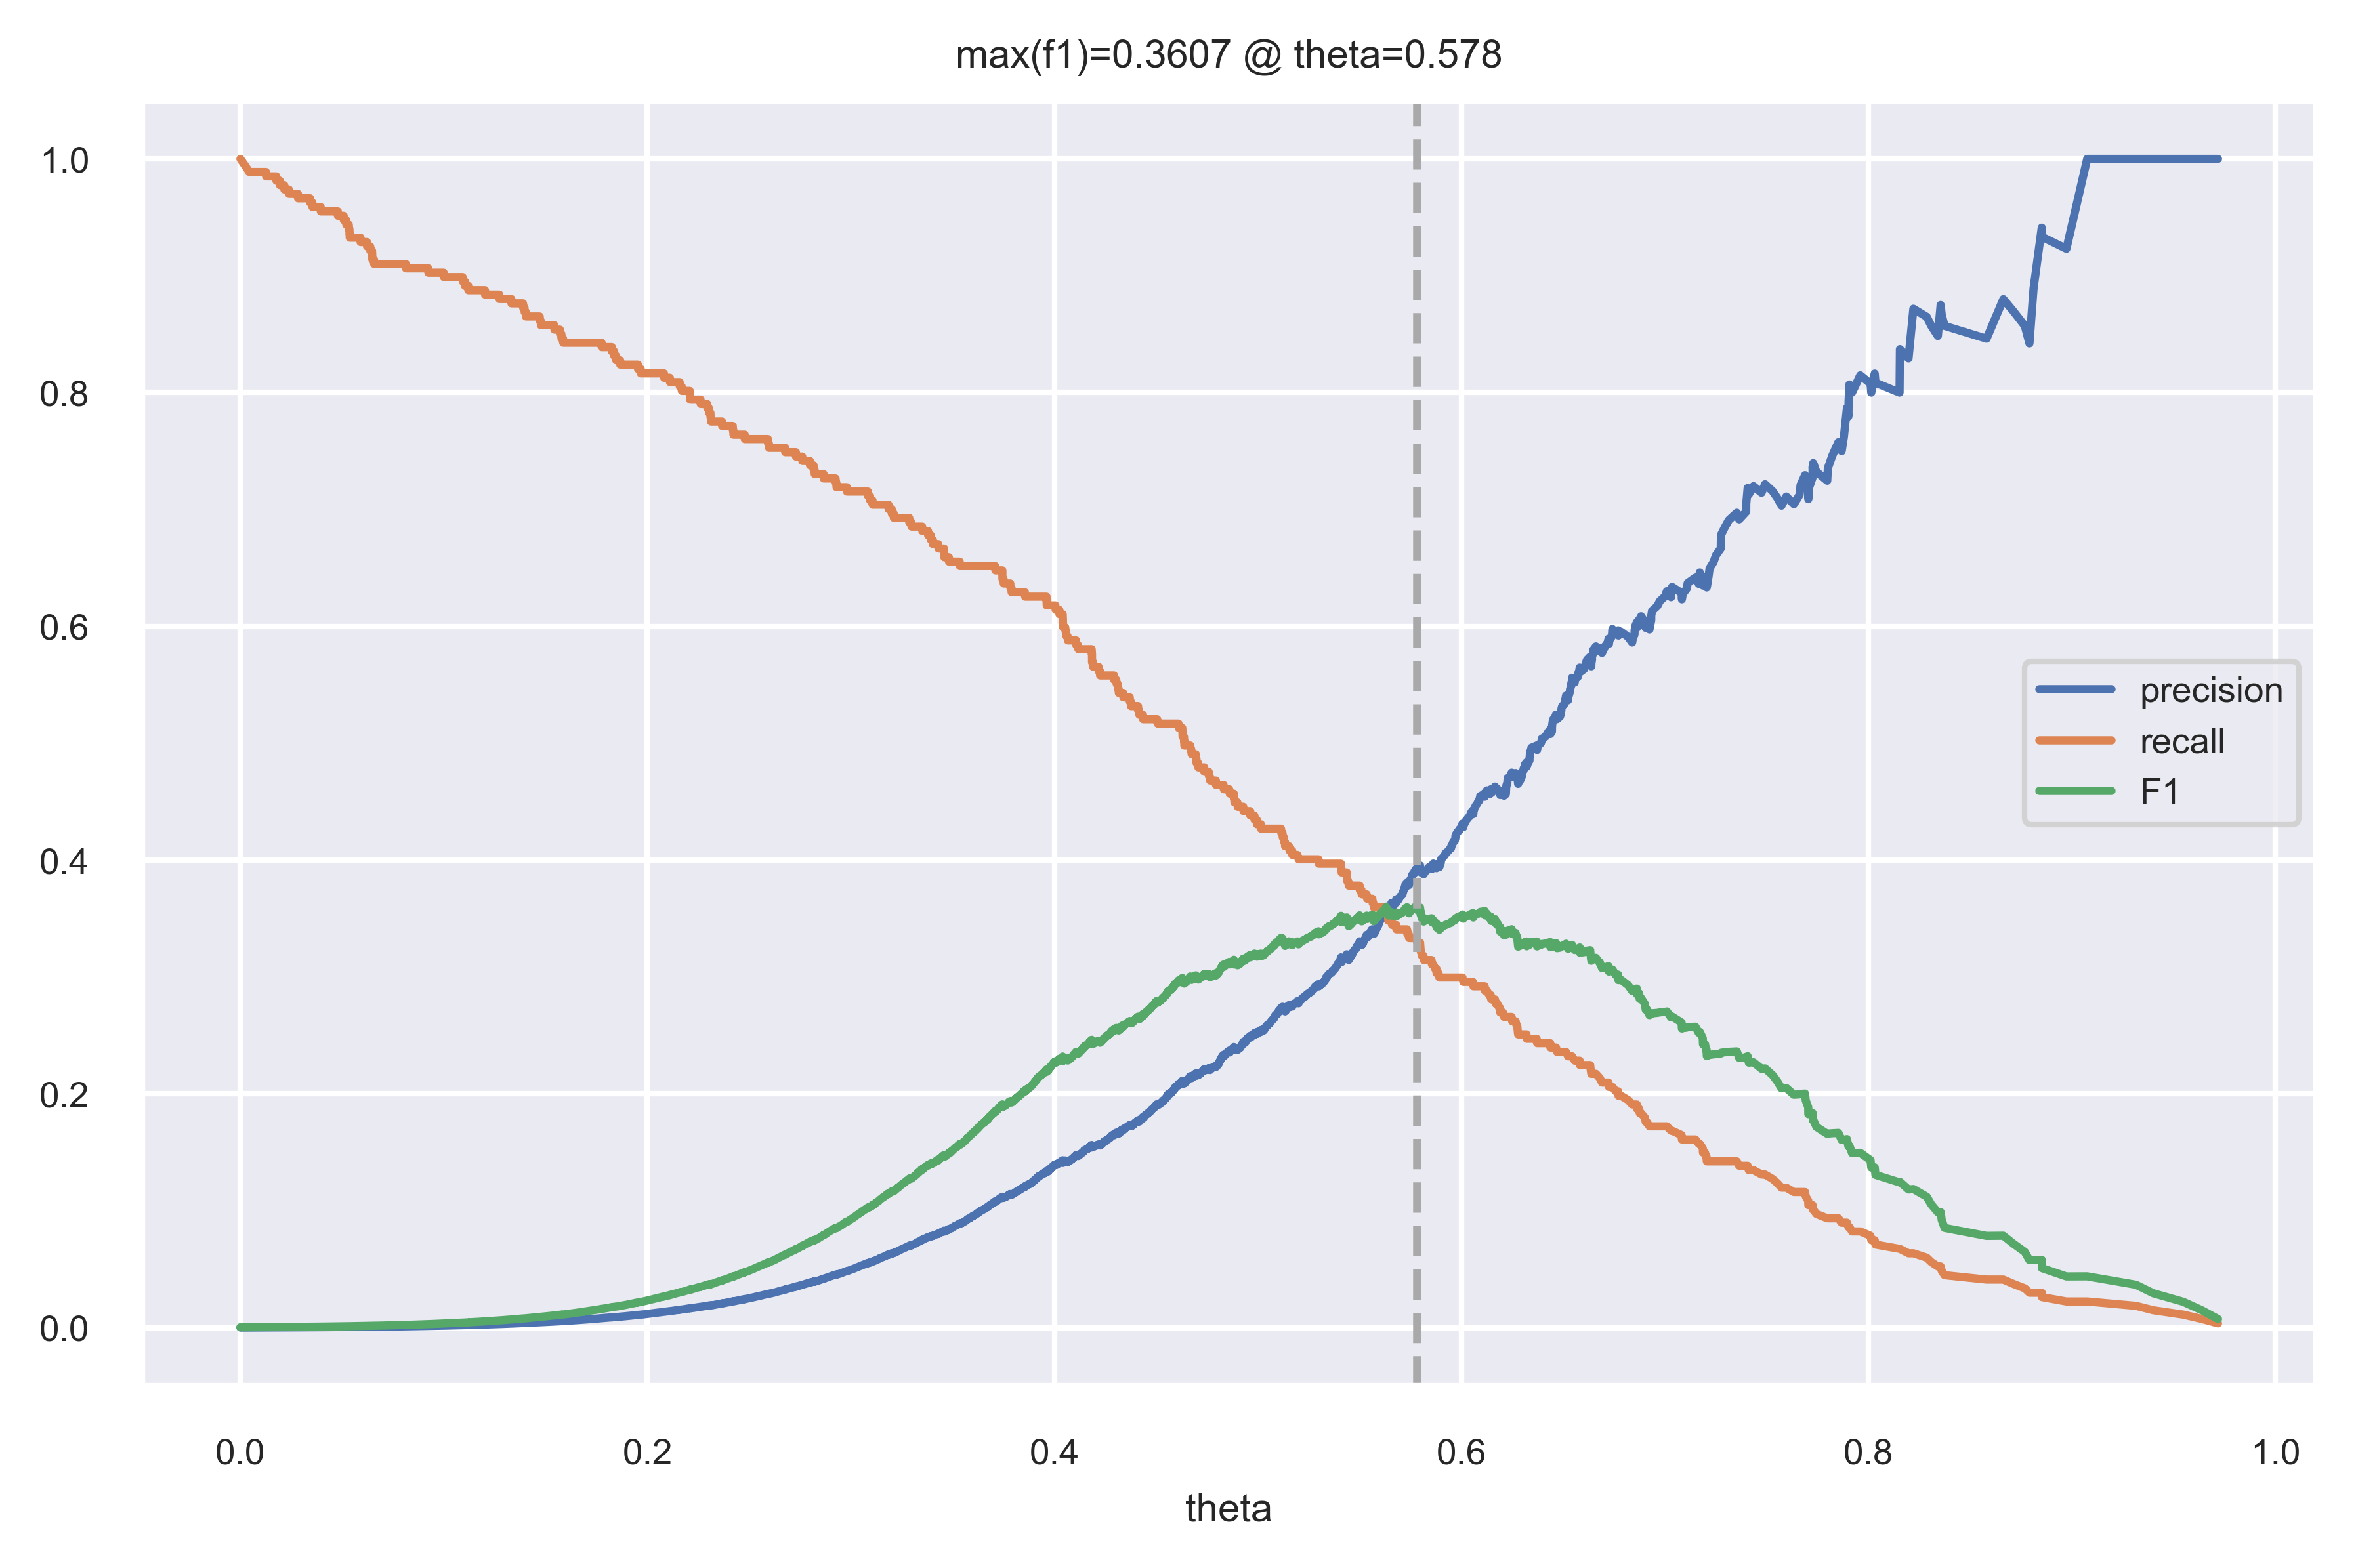

In [70]:
vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

plt.tight_layout()
plt.savefig(f'{fig_dir}/threshold.png');

We've set these values:

In [71]:
print('optim_vs =', optim_vs)
print('optim_rw =', optim_rw)
print('optim_th =', 1 - max_f1_th)

optim_vs = 7000
optim_rw = 0.1693877551020408
optim_th = 0.4220201050024531
